# Set Up and Data Processing

In [1]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
torch.cuda.empty_cache()

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [5]:
# take 5% of data with a different seed than previous trail11
train_df, valid_df = data.data_processing(path, 'Atelectasis', 8, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(11071, 2)

Validation shape
(234, 2)


In [6]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00006/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00031/study1/...,-1.0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0.0
3,CheXpert-v1.0-small/train/patient00031/study2/...,1.0
4,CheXpert-v1.0-small/train/patient00044/study7/...,-1.0


In [7]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Ignore_: Drop Uncertain (-1) Labels

In [8]:
train_df = train_df[train_df['Atelectasis'] != -1].reset_index(drop=True)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [9]:
train_df.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00006/study1/...,0
1,CheXpert-v1.0-small/train/patient00031/study3/...,0
2,CheXpert-v1.0-small/train/patient00031/study2/...,1
3,CheXpert-v1.0-small/train/patient00044/study6/...,1
4,CheXpert-v1.0-small/train/patient00044/study6/...,1
5,CheXpert-v1.0-small/train/patient00044/study2/...,1
6,CheXpert-v1.0-small/train/patient00044/study3/...,0
7,CheXpert-v1.0-small/train/patient00044/study1/...,1
8,CheXpert-v1.0-small/train/patient00044/study4/...,0
9,CheXpert-v1.0-small/train/patient00049/study1/...,0


In [10]:
train_df.shape

(9416, 2)

# Set Up For DL Training

In [11]:
tfms = get_transforms(do_flip=False, flip_vert=False)

In [12]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [13]:
src = src.split_by_rand_pct(0.1)

In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7601MB of GPU RAM free


In [15]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [16]:
print(data.c)
print(data.classes)

2
[0, 1]


In [17]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [18]:
learn11 = cnn_learner(data=data, base_arch=models.densenet121, metrics=accuracy, pretrained=True, callback_fns=AUROC)

In [19]:
learn11.load('learn11-rd-1-rn121')

Learner(data=ImageDataBunch;

Train: LabelList (8475 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,1,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (941 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.77E-07
Min loss divided by 10: 1.48E-07


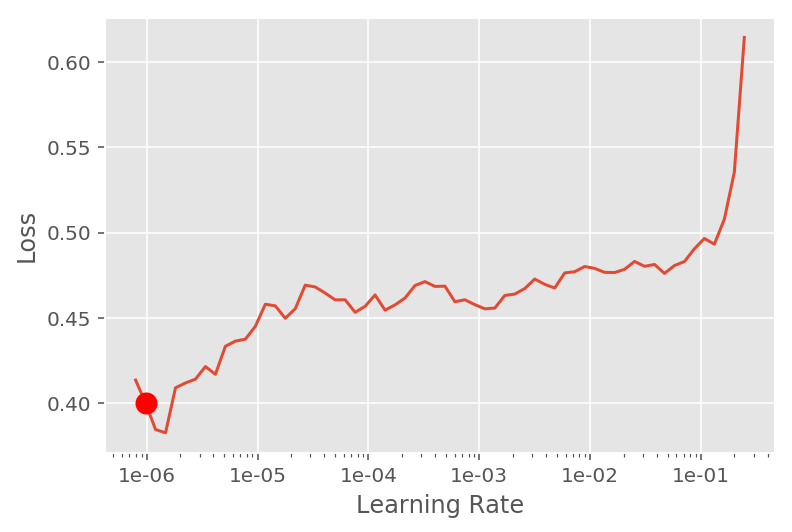

In [20]:
learn11.lr_find(start_lr=1e-7, end_lr=100)
learn11.recorder.plot(suggestion=True)

In [21]:
lr = learn11.recorder.min_grad_lr
lr

9.772372209558107e-07

# Rd. 1 Training

In [22]:
learn11.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.437441,0.438514,0.840595,0.591572,03:18
1,0.459065,0.434439,0.840595,0.593316,03:14
2,0.433536,0.434914,0.840595,0.593493,03:14
3,0.452675,0.436008,0.840595,0.592727,03:14
4,0.438343,0.435785,0.840595,0.593873,03:14


In [23]:
learn11.save('learn11-rd-1-newdata')

# New Data Set (train_df2)

In [29]:
from capstone import data
# take 5% of data with a different seed than previous trail11
train_df2, valid_df2 = data.data_processing(path, 'Atelectasis', 101, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(10818, 2)

Validation shape
(234, 2)


In [30]:
train_df2 = train_df2[train_df2['Atelectasis'] != -1].reset_index(drop=True)
train_df2['Atelectasis'] = train_df2['Atelectasis'].astype(int)

In [32]:
train_df2.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00003/study1/...,0
1,CheXpert-v1.0-small/train/patient00023/study1/...,0
2,CheXpert-v1.0-small/train/patient00023/study1/...,0
3,CheXpert-v1.0-small/train/patient00023/study4/...,0
4,CheXpert-v1.0-small/train/patient00023/study4/...,0
5,CheXpert-v1.0-small/train/patient00023/study11...,0
6,CheXpert-v1.0-small/train/patient00023/study11...,0
7,CheXpert-v1.0-small/train/patient00023/study2/...,0
8,CheXpert-v1.0-small/train/patient00023/study2/...,0
9,CheXpert-v1.0-small/train/patient00023/study10...,0


In [35]:
train_df2.shape

(9200, 2)

# Set Up For DL Training (w/ new train_df2)

In [39]:
src2 = (ImageList.from_df(df=train_df2, path=path, folder='.', suffix=''))

In [40]:
src2 = src2.split_by_rand_pct(0.1)

In [41]:
data2 = (src2.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [42]:
data2.c

2

In [43]:
data2.classes

[0, 1]

In [44]:
learn11.data = data2

# Rd. 2 Training w/ new data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.39E-06
Min loss divided by 10: 2.09E-04


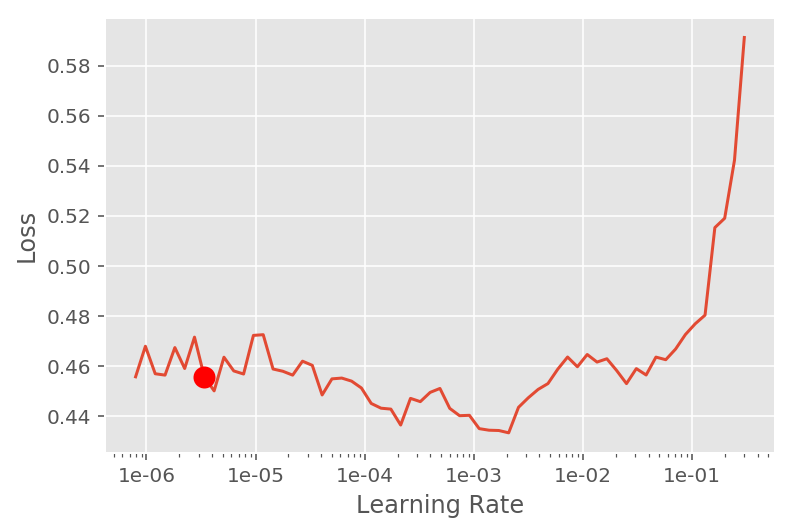

In [45]:
learn11.lr_find(start_lr=1e-7, end_lr=100)
learn11.recorder.plot(suggestion=True)

In [63]:
lr = 1e-03

In [47]:
learn11.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.465209,0.448543,0.825000,0.648287,03:13
1,0.464140,0.449145,0.825000,0.637419,03:10
2,0.441947,0.438384,0.825000,0.675644,03:10
3,0.451988,0.436035,0.825000,0.678156,03:10
4,0.433857,0.438090,0.825000,0.675963,03:10


In [48]:
learn11.save('learn11-rd-2-newdata')

# New Data Set (train_df3)

In [53]:
from capstone import data
# take 5% of data with a different seed than previous trail11
train_df3, valid_df3 = data.data_processing(path, 'Atelectasis', 321, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(11957, 2)

Validation shape
(234, 2)


In [54]:
train_df3 = train_df3[train_df3['Atelectasis'] != -1].reset_index(drop=True)
train_df3['Atelectasis'] = train_df3['Atelectasis'].astype(int)

In [55]:
train_df3.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00065/study2/...,0
1,CheXpert-v1.0-small/train/patient00065/study2/...,0
2,CheXpert-v1.0-small/train/patient00065/study1/...,0
3,CheXpert-v1.0-small/train/patient00065/study1/...,0
4,CheXpert-v1.0-small/train/patient00090/study1/...,1


In [56]:
train_df3.shape

(10174, 2)

# Set Up For DL Training (w/ new train_df3)

In [57]:
src3 = (ImageList.from_df(df=train_df3, path=path, folder='.', suffix=''))

In [58]:
src3 = src3.split_by_rand_pct(0.1)

In [59]:
data3 = (src3.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [60]:
print(data3.c)
print(data3.classes)

2
[0, 1]


In [61]:
learn11.load('learn11-rd-2-newdata');

In [62]:
learn11.data = data3

# Rd. 3 Training w/ new data (train_df3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 1.82E-07


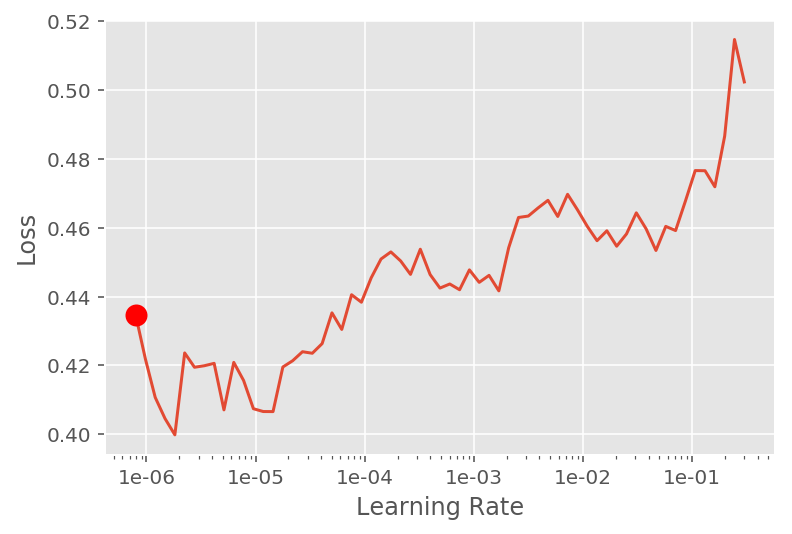

In [64]:
learn11.lr_find(start_lr=1e-7, end_lr=100)
learn11.recorder.plot(suggestion=True)

In [65]:
learn11.fit_one_cycle(3, 1e-06)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.443431,0.440997,0.822026,0.674304,04:47
1,0.456543,0.441924,0.822026,0.677285,04:38
2,0.446259,0.439134,0.822026,0.679069,04:38


In [66]:
learn11.save('learn11-rd-3-newdata')